<a href="https://colab.research.google.com/github/Jorbnc/MAIA-RL/blob/master/RL_proyecto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tablero

In [ ]:
# Para anotar los tipos de argumentos del tablero
from typing import Tuple, List

#Validar que el número de celda esté dentro de los límites del tablero
def limites_validos(celda, celda_max) -> bool:
    return 1 <= celda <= celda_max


class Tablero:
    def __init__(
        self,
        nro_filas: int,
        nro_columnas: int,
        celda_victoria: int,
        celdas_perdida: List[int],
        celdas_escalera: List[Tuple[int]],
        celdas_rodadero: List[Tuple[int]],
    ):
        # ----------------------------------------------------------------------
        # Validación de celdas
        if nro_filas < 2 or nro_columnas < 2:
            raise ValueError("Debe haber al menos 2 filas y 2 columnas")
        self.celda_max = nro_filas * nro_columnas
        celdas_a_validar = ([celda_victoria] + celdas_perdida
                            + [celda for par in celdas_escalera for celda in par]
                            + [celda for par in celdas_rodadero for celda in par]
                            )
        for celda in celdas_a_validar:
            if not limites_validos(celda, self.celda_max):
                raise ValueError(f"{celda} fuera de los limites: {1} a {self.celda_max}")

        # ----------------------------------------------------------------------
        # Atributos
        self.nro_filas = nro_filas
        self.nro_columnas = nro_columnas
        self.celda_victoria = celda_victoria
        self.celdas_perdida = [c for c in celdas_perdida if c != celda_victoria]
        self.celdas_escalera = celdas_escalera
        self.celdas_rodadero = celdas_rodadero

        # Ya que la transición desde el inicio hacia el final de una escalera tiene la misma
        # lógica que la de un rodadero, podemos manejar este "movimiento" con un solo diccionario
        self.escaleras_y_rodaderos = {inicio: fin for inicio, fin in zip(
            # Inicio de escaleras y rodaderos
            [a for (a, b) in self.celdas_escalera] + [a for (a, b) in self.celdas_rodadero],
            # Fin de escaleras y rodaderos
            [b for (a, b) in self.celdas_escalera] + [b for (a, b) in self.celdas_rodadero]
        )}

        # Reward para los casos relevantes: ganar o perder el juego
        # (implícitamente se define un reward 0 para todos los otros casos)
        self.reward_map = {
            self.celda_victoria: 1.0,
            **{cell: -1.0 for cell in self.celdas_perdida}
        }

    def __repr__(self) -> str:
        """Representación impresa del Tablero"""
        atributos = [
            ("Número de filas", self.nro_filas),
            ("Número de columnas", self.nro_columnas),
            ("Celda máxima", self.celda_max),
            ("Celda victoria", self.celda_victoria),
            ("Celdas perdida", self.celdas_perdida),
            ("Celdas escalera", self.celdas_escalera),
            ("Celdas rodadero", self.celdas_rodadero),
        ]
        atributos_str = "\n".join(f" {nombre}: {valor}" for nombre, valor in atributos)
        return f"Tablero:\n{atributos_str}\n"

    def celda_a_coord(self, nro_celda) -> tuple[int, int]:
        """Obtener coordenada (columna, fila) a partir del número de celda y el número de columnas."""

        # -1 para manejar los multiplos de 'nro_columnas'
        fila = ((nro_celda - 1) // self.nro_columnas) + 1
        offset = (nro_celda - 1) % self.nro_columnas

        if fila % 2 == 1:  # Fila impar
            columna = offset + 1  # Izquierda a derecha
        else:
            columna = self.nro_columnas - offset  # Derecha a izquierda
        return (columna - 0.5, fila - 0.5)  # Centrar

    def coord_a_celda(self, col, fila) -> int:
        """Obtener el número de celda a partir del par: (columna, fila)"""
        valor_inicial = (fila - (fila % 2)) * self.nro_columnas
        offset = (-1) ** (fila - 1) * (col - ((fila - 1) % 2))
        return valor_inicial + offset


# Para exportar/importar con `from Tablero import *``
__all__ = ["limites_validos", "Tablero"]


# Visualización

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.animation as animation


def plot_tablero(tablero, trayectoria=None) -> None:
    """
    Plotear el tablero.
    Si se pasa una trayectoria, se mostrará una animación con el recorrido del agente.
    """
    nro_filas, nro_columnas = tablero.nro_filas, tablero.nro_columnas

    fig, ax = plt.subplots(figsize=(nro_columnas, nro_filas), dpi=75)
    ax.set_xlim(0, nro_columnas)
    ax.set_ylim(0, nro_filas)
    ax.set_xticks(range(1, nro_columnas + 1))
    ax.set_yticks(range(1, nro_filas + 1))
    ax.grid(color="black", linewidth=1)
    ax.tick_params(
        axis="both", which="both",
        bottom=False, top=False, left=False, right=False,
        labelbottom=False, labelleft=False,
    )

    # Anotar el número de celda
    for fila in range(1, nro_filas + 1):
        for col in range(1, nro_columnas + 1):
            nro_celda = tablero.coord_a_celda(col, fila)
            ax.text(col - 0.5, fila - 0.35, str(nro_celda), ha="center", va="bottom", alpha=0.5)

    # Posición de victoria
    vic_coord = tablero.celda_a_coord(tablero.celda_victoria)
    ax.text(*vic_coord, "FIN", ha="center", va="top", color="green", size=15)

    # Posiciones de pérdida
    for celda in tablero.celdas_perdida:
        ax.scatter(*tablero.celda_a_coord(celda), color="red", s=150, marker="X")

    # Escaleras
    for par in tablero.celdas_escalera:
        x1, y1 = tablero.celda_a_coord(par[0])
        x2, y2 = tablero.celda_a_coord(par[1])
        arrow = mpatches.FancyArrow(x1, y1, x2 - x1, y2 - y1,
                                    width=0.08, length_includes_head=True,
                                    color="green", alpha=0.5)
        ax.add_patch(arrow)

    # Rodaderos
    for par in tablero.celdas_rodadero:
        x1, y1 = tablero.celda_a_coord(par[0])
        x2, y2 = tablero.celda_a_coord(par[1])
        arrow = mpatches.FancyArrow(x1, y1, x2 - x1, y2 - y1,
                                    width=0.08, length_includes_head=True,
                                    color="red", alpha=0.5)
        ax.add_patch(arrow)

    # Animar trayectoria
    if trayectoria:
        dot, = ax.plot([], [], 'bo', markersize=12) # Figura del agente. Se actualiza iterativamente

        def actualizar_frame(frame):
            coord = tablero.celda_a_coord(trayectoria[frame])
            dot.set_data([coord[0]], [coord[1]]) # set_data espera un array, no valores escalares
            return dot, # tuple (con 1 solo elemento) para que FuncAnimation pueda 'iterar' y re-dibujar el dot

        anim = animation.FuncAnimation( # Es necesario asignar a una variable para que el GC no lo elimine
            fig,
            actualizar_frame, # Función para llamar por cada frame
            frames=len(trayectoria), # Total de frames
            interval=200, # milisegundos
            repeat=True, # loopear la animación
            blit=True, # re-dibujar solo figuras que han cambiado
        )

    plt.show()


# Agente

In [ ]:
import random
from typing import Tuple, List
#from tablero import Tablero


class AgenteQLearning:
    def __init__(self, tablero: Tablero, alpha: float = 0.1, gamma: float = 0.9, epsilon: float = 0.1):

        # Ambiente
        self.tablero = tablero

        # Parámetros del agente
        self.alpha = alpha  # Tasa de aprendizaje
        self.gamma = gamma  # Factor de descuento
        self.epsilon = epsilon  # Ratio de exploración
        self.pos = 1 # Inicialización de la posición
        self.acciones = [-1, 1] # Izquierda/Derecha o Arriba/Abajo en los bordes del tablero

        # Q-table (o Q-dict en nuestro caso)
        # Es un mapeo (estado, acción) -> Q estimado (actualizado iterativamente)
        self.Q = {}

    def escoger_accion(self, estado) -> int:
        """Escoge una acción con el método epsilon-greedy"""

        # Exploración
        if random.random() < self.epsilon:
            return random.choice(self.acciones)

        # Explotación
        else:
            # Obtener los mejores valores Q (0 en caso aún no exista)
            Q_vals = [self.Q.get((estado, a), 0.0) for a in self.acciones]
            Q_max = max(Q_vals)

            # En caso de empate, escoger aleatoriamente una acción
            mejores_acciones = [a for a, Q in zip(self.acciones, Q_vals) if Q == Q_max]
            return random.choice(mejores_acciones)

    def actualizar_Q(self, estado, accion, reward, estado_siguiente) -> None:
        """
        Actualización Q-learning con base en(Sₜ,Aₜ,Rₜ,Sₜ₊₁):
            Q(Sₜ,Aₜ) = Q(Sₜ,Aₜ) + α[Rₜ₊₁ + γ*maxₐ Q(Sₜ₊₁,a) - Q(Sₜ,Aₜ)]    (Sutton & Barto, p. 131)
        """
        Q_actual = self.Q.get((estado, accion), 0.0)

        # Estimar mejor Q en el siguiente estado
        Q_vals_siguiente_max = max([self.Q.get((estado_siguiente, a), 0.0) for a in self.acciones])

        # Actualización
        # TODO: Probar si hay cambios importantes al variar gamma
        self.Q[(estado, accion)] = Q_actual + self.alpha * (reward + self.gamma * Q_vals_siguiente_max - Q_actual)

    def transicion(self, estado, accion):
        """
        Función de transición que retorna una celda entre dos posibles opciones:
            - El final de una escalera/rodadero
            - Otra celda válida dentro del tablero
        """
        estado_siguiente = estado + accion
        estado_siguiente = self.tablero.escaleras_y_rodaderos.get(
            # Si el estado_siguiente es el inicio de una escalera/rodadero, entonces retorna el final
            estado_siguiente,
            # En caso contrario, solo valida el estado_siguiente
            max(1, min(estado_siguiente, self.tablero.celda_max))
        )
        # WARNING: No se llega a evaluar una condición de finalización aquí
        # ya que eso se está manejando externamente en simulacion.py
        return estado_siguiente

    def reward(self, estado_siguiente):
        """
        Función de recompensa basado en un mapeo (diccionario): Sₜ₊₁ -> reward
            - +1 para celda victoria
            - -1 para celdas perdida
            - 0 para los otros casos
        """
        return self.tablero.reward_map.get(estado_siguiente, 0)

    def step(self) -> Tuple[int, int, float, int]:
        """
        Representa un paso en la simulación con base en las condiciones actuales.
        Actualiza la Q-table con base en (Sₜ,Aₜ,Rₜ,Sₜ₊₁) y retorna la tupla.
        """

        estado = self.pos
        accion = self.escoger_accion(estado)

        # Transición y Reward del paso actual
        estado_siguiente = self.transicion(estado, accion)
        reward = self.reward(estado_siguiente)

        # Actualizar Q y estado (pos)
        self.actualizar_Q(estado, accion, reward, estado_siguiente)
        self.pos = estado_siguiente

        return estado, accion, reward, estado_siguiente

# Simulación

In [ ]:
#from visualizacion import plot_tablero
import matplotlib.pyplot as plt
import numpy as np


def run(tablero, agente, episodios=1000) -> None:
    """Correr simulación y plotear la última trayectoria."""

    reward_acumulado = []

    for episodio in range(episodios):
        # Reiniciar condiciones al inicio de cada episodio
        agente.pos = 1
        trayectoria = [agente.pos]
        pasos = 0

        # Recorrer tablero
        while True:
            estado, accion, reward, estado_siguiente = agente.step()
            pasos += 1
            trayectoria.append(estado_siguiente)
            reward_acumulado.append(reward)

            # Evaluar si hay condición de finalización
            if estado_siguiente == agente.tablero.celda_victoria or estado_siguiente in agente.tablero.celdas_perdida:
                print(f"Episodio {episodio + 1} terminó en {pasos} pasos, con reward {reward}.")
                break

    #plt.plot(np.cumsum(reward_acumulado))
    #plt.show()
    plot_tablero(tablero, trayectoria)

# Main

Episodio 1 terminó en 104 pasos, con reward -1.0.
Episodio 2 terminó en 342 pasos, con reward -1.0.
Episodio 3 terminó en 161 pasos, con reward -1.0.
Episodio 4 terminó en 371 pasos, con reward 1.0.
Episodio 5 terminó en 475 pasos, con reward 1.0.
Episodio 6 terminó en 157 pasos, con reward -1.0.
Episodio 7 terminó en 64 pasos, con reward -1.0.
Episodio 8 terminó en 465 pasos, con reward -1.0.
Episodio 9 terminó en 266 pasos, con reward 1.0.
Episodio 10 terminó en 60 pasos, con reward -1.0.
Episodio 11 terminó en 162 pasos, con reward -1.0.
Episodio 12 terminó en 207 pasos, con reward -1.0.
Episodio 13 terminó en 105 pasos, con reward -1.0.
Episodio 14 terminó en 182 pasos, con reward -1.0.
Episodio 15 terminó en 92 pasos, con reward -1.0.
Episodio 16 terminó en 653 pasos, con reward 1.0.
Episodio 17 terminó en 408 pasos, con reward 1.0.
Episodio 18 terminó en 217 pasos, con reward 1.0.
Episodio 19 terminó en 165 pasos, con reward -1.0.
Episodio 20 terminó en 1031 pasos, con reward -1.

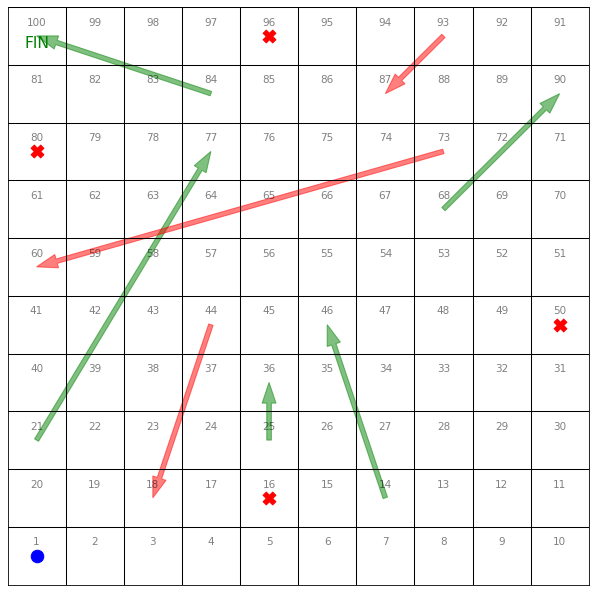

In [ ]:
#from tablero import Tablero
#from agente import AgenteQLearning
#from visualizacion import plot_tablero
#from simulacion import run
import time

##
tab = Tablero(
    nro_filas=10,
    nro_columnas=10,
    celda_victoria=100,
    celdas_perdida=[16, 50, 80, 96],
    celdas_escalera=[(14, 46), (21, 77), (25, 36), (68, 90), (84, 100)],
    celdas_rodadero=[(44, 18), (73, 60), (93, 87)],
)
agente = AgenteQLearning(tab, epsilon=0.1, gamma=0.5)
run(tab, agente, episodios=100)